In [165]:
import os
import sys
import argparse
import numpy as np
import torch
import pandas as pd
import nibabel as nib    
from pathlib import Path
from surface_distance import metrics
from tqdm import tqdm
import torch.nn as nn
import ants
import json

In [166]:
def pred_invert_resample(path_to_pred, path_to_orig, path_to_resampled):
    # path_to_pred = *npz, path_to_orig = *1_reg, path_to_resampled = *4a_resample
    # *.npz archives sometimes can be recognised wrong, if extracted and saved back at the same time
#     data = np.load(path_to_pred, allow_pickle=True)['arr_0']
    # schw
    if np.shape(data)[0] == 1:
        data = data.transpose(0,3,2,1).astype('float32')
        old_orig = ants.image_read(path_to_resampled)
        new_orig = ants.image_read(path_to_orig)
        old_like = old_orig.new_image_like(data[0])
        new_img = ants.resample_image(old_like, new_orig.spacing, False, 0)
        output_file = new_img.numpy().astype('float16')
    
    # gbm and lgg
    elif np.shape(data)[0] > 1:
        data = data.transpose(0,3,2,1).astype('float32')

        old_orig_ct1 = ants.image_read(path_to_resampled)
        new_orig_ct1 = ants.image_read(path_to_orig)

        old_like_ch_0 = old_orig_ct1.new_image_like(data[0])
        old_like_ch_1 = old_orig_ct1.new_image_like(data[1])
        old_like_ch_2 = old_orig_ct1.new_image_like(data[2])

        new_img_0 = ants.resample_image(old_like_ch_0, new_orig_ct1, False, 0)
        new_img_1 = ants.resample_image(old_like_ch_1, new_orig_ct1, False, 0)
        new_img_2 = ants.resample_image(old_like_ch_2, new_orig_ct1, False, 0)

        new_img_shape =  new_img_2.numpy().shape

        new_array = np.zeros(tuple([3] + list(new_img_shape)), dtype='float16')
        new_array[0] = new_img_0.numpy()
        new_array[1] = new_img_1.numpy()
        new_array[2] = new_img_2.numpy()
        output_file = new_array.transpose(0,3,2,1).astype('float16')
    return (output_file)

def pred_invert_resample_1cl(data,mat_fie_sub, path_to_orig, path_to_resampled, mod = None):
    # path_to_pred = *npz, path_to_orig = *1_reg, path_to_resampled = *4a_resample
    # *.npz archives sometimes can be recognised wrong, if extracted and saved back at the same time
#     data = np.load(path_to_pred, allow_pickle=True)['arr_0']
    # schw
        data = data.transpose(0,3,2,1).astype('float32')
#         print('data')
#         print(data.shape)
        old_orig = ants.image_read(path_to_resampled)
#         print('old_orig')
#         print(old_orig.shape)
        
        new_orig = ants.image_read(path_to_orig)
        old_like = old_orig.new_image_like(data[0])
        if mod == '3a_atlas':
#             print('a')
            new_img = ants.apply_transforms(new_orig, old_like, whichtoinvert=[True],
                                      transformlist = mat_fie_sub)
        elif mod == '2a_interp':
#             print('cehck')
            new_img = ants.resample_image(old_like, new_orig.shape, True, 0)
        else:
            new_img = ants.resample_image(old_like, new_orig.spacing, False, 0)
#         print('new_img')
#         print(new_img.shape)
        output_file = new_img.numpy().astype('float16')
#         print(new_orig.shape)
#         print(output_file.shape)
#         print(new_orig.shape)
        if (new_orig.shape[0]-output_file.shape[0] < 0 ) or (new_orig.shape[1]-output_file.shape[1] < 0) or (new_orig.shape[2]-output_file.shape[2] < 0):
            print('1')
            output_file = output_file[:new_orig.shape[0], :new_orig.shape[1],:new_orig.shape[2] ]
        if (new_orig.shape[0]-output_file.shape[0] > 0) or (new_orig.shape[1]-output_file.shape[1] > 0) or (new_orig.shape[2]-output_file.shape[2] > 0):
            print('2')
            output_file = np.pad(output_file, ((0, new_orig.shape[0]-output_file.shape[0]), (0, new_orig.shape[1]-output_file.shape[1]), (0, new_orig.shape[2]-output_file.shape[2])), 'constant', constant_values=0)

#         output_file = output_file[:new_orig.shape[0], :new_orig.shape[1],:new_orig.shape[2] ]
#         print(output_file.shape)
#         print(output_file.shape)
        return (output_file)
    
def pred_invert_resample_classes(data, mat_file_path, path_to_orig, path_to_resampled, mod):

    # gbm and lgg
        data = data.transpose(0,3,2,1).astype('float32')
#         print(data.shape)
        old_orig_ct1 = ants.image_read(path_to_resampled)
        new_orig_ct1 = ants.image_read(path_to_orig)
    
#         print(old_orig_ct1.shape)
#         print(new_orig_ct1.shape)
        old_like_ch_0 = old_orig_ct1.new_image_like(data[0])
        old_like_ch_1 = old_orig_ct1.new_image_like(data[1])
        old_like_ch_2 = old_orig_ct1.new_image_like(data[2])
#         print('old_like')
# #         print(old_like_ch_2.shape)
        if mod == '2a_interp':
            new_img_0 = ants.resample_image(old_like_ch_0, new_orig_ct1.shape, True, 0)
            new_img_1 = ants.resample_image(old_like_ch_1, new_orig_ct1.shape, True, 0)
            new_img_2 = ants.resample_image(old_like_ch_2, new_orig_ct1.shape, True, 0)
        if mod == '3a_atlas':
            new_img_0 = ants.apply_transforms(new_orig_ct1, old_like_ch_0, whichtoinvert=[True],
                                          transformlist = mat_file_path)
            new_img_1 = ants.apply_transforms(new_orig_ct1, old_like_ch_1, whichtoinvert=[True],
                                          transformlist = mat_file_path)
            new_img_2 = ants.apply_transforms(new_orig_ct1, old_like_ch_2, whichtoinvert=[True],
                                          transformlist = mat_file_path)
        else:
            new_img_0 = ants.resample_image(old_like_ch_0, new_orig_ct1.spacing, False, 0)
            new_img_1 = ants.resample_image(old_like_ch_1, new_orig_ct1.spacing, False, 0)
            new_img_2 = ants.resample_image(old_like_ch_2, new_orig_ct1.spacing, False, 0)
       
        new_img_shape =  new_img_2.numpy().shape

        new_array = np.zeros(tuple([3] + list(new_img_shape)), dtype='float16')
        new_array[0] = new_img_0.numpy()
        new_array[1] = new_img_1.numpy()
        new_array[2] = new_img_2.numpy()
        output_file = new_array.astype('float16')
#         print(output_file.shape)
#         print('check_shape')
#         print(new_orig_ct1.shape)
#         print(new_orig_ct1.shape[2]-output_file.shape[3])
#         print((new_orig_ct1.shape[1]-output_file.shape[2]))
#         print((new_orig_ct1.shape[0]-output_file.shape[1]))
        if (new_orig_ct1.shape[2]-output_file.shape[3] < 0 ) or (new_orig_ct1.shape[1]-output_file.shape[2] < 0) or (new_orig_ct1.shape[0]-output_file.shape[1] < 0):
            print(1)
            output_file = output_file[:, :new_orig_ct1.shape[0], :new_orig_ct1.shape[1],:new_orig_ct1.shape[2] ]
            
        if (new_orig_ct1.shape[2]-output_file.shape[3] > 0) or (new_orig_ct1.shape[1]-output_file.shape[2] > 0 ) or (new_orig_ct1.shape[0]-output_file.shape[1] > 0):
            print(2)
            output_file = np.pad(output_file, ((0,0), (0, new_orig_ct1.shape[0]-output_file.shape[1]), (0, new_orig_ct1.shape[1]-output_file.shape[2]), (0, new_orig_ct1.shape[2]-output_file.shape[3])), 'constant', constant_values=0)

        output_file = output_file[:,:new_orig_ct1.shape[0], :new_orig_ct1.shape[1],:new_orig_ct1.shape[2] ]
#         print(output_file.shape)
        
        return (output_file)

In [167]:
def sensitivity_and_specificity(mask_gt, mask_pred):
    """ Computes sensitivity and specificity
     sensitivity  = TP/(TP+FN)
     specificity  = TN/(TN+FP) """
    volume_sum = mask_gt.sum() + mask_pred.sum()
    tp = (mask_gt & mask_pred).sum()
    tn = (~mask_gt & ~mask_pred).sum()
    fp = (~mask_gt & mask_pred).sum()
    fn = (mask_gt & ~mask_pred).sum()
#     TP/(TP+FP) - precision; TP/(TP+FN) - recall
    return tp/(tp+fn), tp/(tp+fp), tn/(tn+fp)

In [168]:
def calculate_metrics_brats_1cl(true_mask, pred_mask, ids, spaces):
    """ Takes two file locations as input and validates surface distances.
    Be careful with dimensions of saved `pred` it should be 3D.
    
    """
    
    _columns = ['Ids','Dice_1',
                'Hausdorff95_1',
                'Sensitivity_1',
               'Specificity_1',
               'Surface_dice_1',
               'Precision_1']
    
    df = pd.DataFrame(columns = _columns)
    df.at[0,'Ids'] = ids
    #class 1
    distances = metrics.compute_surface_distances((true_mask==1), (pred_mask==1), spaces)
    df.at[0,'Dice_1'] = metrics.compute_dice_coefficient((true_mask==1), (pred_mask==1))
    df.at[0,'Surface_dice_1'] = metrics.compute_surface_dice_at_tolerance(distances,1)
    df.at[0,'Hausdorff95_1'] = metrics.compute_robust_hausdorff(distances, 95)
    sens, precision, spec = sensitivity_and_specificity((true_mask==1), (pred_mask==1))
    df.at[0,'Sensitivity_1'] = sens
    df.at[0,'Precision_1'] = precision
    df.at[0,'Specificity_1'] = spec
    return df

def calculate_metrics_brats(true_mask, pred_mask, ids, spaces):
    """ Takes two file locations as input and validates surface distances.
    Be careful with dimensions of saved `pred` it should be 3D.
    
    """
    
    _columns = ['Ids','Dice_1', 'Dice_2', 'Dice_3',
                'Hausdorff95_1', 'Hausdorff95_2', 'Hausdorff95_3',
                'Sensitivity_1', 'Sensitivity_2', 'Sensitivity_3',
               'Specificity_1', 'Specificity_2', 'Specificity_3',
               'Surface_dice_1', 'Surface_dice_2', 'Surface_dice_3',
               'Precision_1', 'Precision_2', 'Precision_3']
    
    
    df = pd.DataFrame(columns = _columns)
    df.at[0,'Ids'] = ids
    #class 1
    distances = metrics.compute_surface_distances((true_mask[0,:,:,:]==1), (pred_mask[0,:,:,:]==1), spaces)
    df.at[0,'Dice_1'] = metrics.compute_dice_coefficient((true_mask[0,:,:,:]==1), (pred_mask[0,:,:,:]==1))
    df.at[0,'Surface_dice_1'] = metrics.compute_surface_dice_at_tolerance(distances,1)
    df.at[0,'Hausdorff95_1'] = metrics.compute_robust_hausdorff(distances, 95)
    sens, precision, spec = sensitivity_and_specificity((true_mask[0,:,:,:]==1), (pred_mask[0,:,:,:]==1))
    df.at[0,'Sensitivity_1'] = sens
    df.at[0,'Precision_1'] = precision
    df.at[0,'Specificity_1'] = spec
    #class 2
    distances = metrics.compute_surface_distances((true_mask[1,:,:,:]==1), (pred_mask[1,:,:,:]==1), spaces)
    df.at[0,'Dice_2'] = metrics.compute_dice_coefficient((true_mask[1,:,:,:]==1), (pred_mask[1,:,:,:]==1))
    df.at[0,'Surface_dice_2'] = metrics.compute_surface_dice_at_tolerance(distances,1)
    df.at[0,'Hausdorff95_2'] = metrics.compute_robust_hausdorff(distances, 95)
    sens,precision, spec= sensitivity_and_specificity((true_mask[1,:,:,:]==1), (pred_mask[1,:,:,:]==1))
    df.at[0,'Sensitivity_2'] = sens
    df.at[0,'Precision_2'] = precision
    df.at[0,'Specificity_2'] = spec
    #class 3
    distances = metrics.compute_surface_distances((true_mask[2,:,:,:]==1), (pred_mask[2,:,:,:]==1), spaces)
    df.at[0,'Dice_3'] = metrics.compute_dice_coefficient((true_mask[2,:,:,:]==1), (pred_mask[2,:,:,:]==1))
    df.at[0,'Surface_dice_3'] = metrics.compute_surface_dice_at_tolerance(distances,1)
    df.at[0,'Hausdorff95_3'] = metrics.compute_robust_hausdorff(distances, 95)
    sens, precision, spec= sensitivity_and_specificity((true_mask[2,:,:,:]==1), (pred_mask[2,:,:,:]==1))
    df.at[0,'Sensitivity_3'] = sens
    df.at[0,'Precision_3'] = precision
    df.at[0,'Specificity_3'] = spec
    return df

In [169]:
    
def calculate_metrics(subjects, path_to_file, path_to_orig, path_to_pred, path_to_resamp, path_to_target, dataset, out = '/home/polina/glioma/all_dice_metrics.csv', mod=None  ):
    
    """ 
    - path_to_pred - path to folder with predict subjects
    - path_to_target - path to folder with target subjects
    - name_pred - name for prediction, ex -brainTumorMask_SRI.nii.gz
    - name_target - name for targets, ex -GTV_to_SRI.nii.gz
    - spaces - if false - [1,1,1]
    - name_csv - name files for each subjects
    - path_csv_all - path to the main file with metrics for each subjects
    """
#     _columns = ['Ids','Dice_1', 'Dice_2', 'Dice_3',
#                 'Hausdorff95_1', 'Hausdorff95_2', 'Hausdorff95_3',
#                 'Sensitivity_1', 'Sensitivity_2', 'Sensitivity_3',
#                'Specificity_1', 'Specificity_2', 'Specificity_3',
#                'Surface_dice_1', 'Surface_dice_2', 'Surface_dice_3',
#                'Precision_1', 'Precision_2', 'Precision_3']
    _columns = ['Ids','Dice_1',
                'Hausdorff95_1',
                'Sensitivity_1',
               'Specificity_1',
               'Surface_dice_1',
               'Precision_1']
    
    af_all = pd.DataFrame(columns = _columns)
    pred_folder = Path(path_to_pred)
    orig_folder = Path(path_to_orig)
    resamp_folder = Path(path_to_resamp)
    target_folder = Path(path_to_target)
    file_folder = Path(path_to_file)
    for ids in tqdm(subjects):
        print(ids)
        pred_sub = os.path.join(pred_folder, ids + '.npy.npz')
        orig_sub = os.path.join(orig_folder, ids,'T1_SEG.nii.gz')
        resamp_sub = os.path.join(resamp_folder, ids,'T1_SEG.nii.gz')
        mat_fie_sub = os.path.join(file_folder, ids,'T1C_to_SRI_fwd.mat')
#         
        targets = ants.image_read(f'{target_folder}/{ids}/T1_SEG.nii.gz')
        spaces = targets.spacing
#         targets = ants.reorient_image2(targets, orientation = 'LAI').numpy()
        targets = targets.numpy()
#         print(targets.shape)
#         print(np.unique(targets))
        data = np.load(pred_sub, allow_pickle=True)['arr_0']
#         print(data.shape)
        if np.shape(data)[0] == 1: 
#             print('check')
#             print(ants.image_read(orig_sub).shape)
#             print(targets.shape)
            prediction = pred_invert_resample_1cl(data, mat_fie_sub, orig_sub, resamp_sub, mod)
            prediction = np.round(prediction, 0)
#         pred = np.transpose(pred, (0, 3, 2, 1))
#             print(prediction.shape)
#             print(np.unique(prediction))
#             print(targets.shape)
#             print(prediction.shape)
            df = calculate_metrics_brats_1cl(targets.astype('int'), prediction.astype('int'), ids, spaces)
#             print(df)
        elif np.shape(data)[0] > 1: 
            prediction = pred_invert_resample_classes(data, mat_fie_sub, orig_sub, resamp_sub, mod)
#             prediction = data.transpose(0,3,2,1).astype('float32')
            prediction = np.round(prediction, 0)
            y_wt, y_tc, y_et = targets > 0, ((targets == 1) + (targets == 3)) > 0, targets == 3
            targets = np.stack([y_wt, y_tc, y_et], axis=0).astype(int)
#             print(targets.shape)
#             print(prediction.shape)
            df=calculate_metrics_brats(targets.astype('int'), prediction.astype('int'), ids, spaces)
#             except:
#                 continue
        os.makedirs(os.path.join(out, dataset,ids), exist_ok = True)
#         print(path_to_pred)
#         out_path = os.path.join(out, dataset,ids, path_to_pred.split('/')[-2] + '_'+ path_to_pred.split('best_')[-1].replace('=', '_') + '.json')
        out_path = os.path.join(out, dataset,ids, path_to_pred.split('/')[-2] + '_'+ path_to_pred.split('predictions_')[-1].replace('=', '_') + '.json')
       #         df.to_json(out_path, orient='records')
        sub_dict = {dataset : {path_to_pred.split('/')[-2]: {path_to_pred.split('_')[-2]: {}}}}
        sub_dict[dataset][path_to_pred.split('/')[-2]][path_to_pred.split('_')[-2]] = df.to_dict('records')[0]
#         print(sub_dict)
        with open(out_path, 'w') as fp:
            json.dump(sub_dict, fp)
        print(df)
        af_all = af_all.append(df)
#     af_all.to_csv(out)  
    print(af_all.mean())
    print(len(af_all))
    return af_all

In [176]:
!cd /data/newdata/schw_infer/ && ls

schw_3a_atlas  schw_3a_atlas_256_patch	schw_3a_atlas_from_brats_TL


In [175]:
orig_folder = '/data_anvar/public_datasets/preproc_study/schw/orig'
resample_folder = '/data_anvar/public_datasets/preproc_study/schw/3a_atlas'
file = '/data_anvar/public_datasets/preproc_study/schw/3a_atlas_mask'
pred_folder = '/data/newdata/schw_infer/schw_3a_atlas_256_patch/predictions_best_epoch=183-dice_mean=87_66_task=37_fold=0_tta'
target_folder = '/data_anvar/public_datasets/preproc_study/schw/1_reg'
reg_1 = '/data_anvar/public_datasets/preproc_study/schw/1_reg'
out_json = '/results/metrics'
dataset = 'schw'
# TCGA-76-4932
subjects = [each[:-8] for each in os.listdir(pred_folder)]
assert(len(subjects) == 242)
# subjects = ['TCGA-02-0027']
calculate_metrics(subjects, file, reg_1, pred_folder, resample_folder, target_folder, dataset, out = out_json, mod='3a_atlas')

  0%|                                                                       | 0/242 [00:00<?, ?it/s]

VS-SEG-146


  0%|▎                                                            | 1/242 [01:21<5:27:37, 81.57s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-146    0.0     18.392685           0.0           1.0            0.0   

  Precision_1  
0         0.0  
VS-SEG-226


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

  1%|▍                                                           | 2/242 [03:20<6:54:41, 103.67s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-226    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-047


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

  1%|▊                                                            | 3/242 [04:21<5:34:14, 83.91s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-047    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-173


  2%|█                                                            | 4/242 [06:16<6:21:58, 96.29s/it]

          Ids    Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1  \
0  VS-SEG-173  0.010749     21.036018       0.00583      0.999943   

  Surface_dice_1 Precision_1  
0       0.067637    0.068858  
VS-SEG-080


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

  2%|█▎                                                           | 5/242 [06:31<4:24:38, 67.00s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-080    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-149


  2%|█▌                                                           | 6/242 [06:56<3:27:53, 52.85s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-149    0.0     23.137769           0.0      0.999981            0.0   

  Precision_1  
0         0.0  
VS-SEG-217


  3%|█▊                                                           | 7/242 [07:13<2:40:26, 40.96s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-217    0.0     22.619313           0.0      0.999929            0.0   

  Precision_1  
0         0.0  
VS-SEG-063


  3%|██                                                           | 8/242 [07:29<2:09:00, 33.08s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-063    0.0     21.494849           0.0      0.999999            0.0   

  Precision_1  
0         0.0  
VS-SEG-195


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

  4%|██▎                                                          | 9/242 [08:08<2:16:05, 35.05s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-195    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-055


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

  4%|██▍                                                         | 10/242 [08:20<1:47:21, 27.77s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-055    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-171


  5%|██▋                                                         | 11/242 [08:31<1:27:54, 22.83s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-171    0.0     19.863267           0.0      0.999995            0.0   

  Precision_1  
0         0.0  
VS-SEG-038


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

  5%|██▉                                                         | 12/242 [08:35<1:05:00, 16.96s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-038    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-095


  5%|███▎                                                          | 13/242 [08:39<49:09, 12.88s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-095    0.0     19.521556           0.0      0.999989            0.0   

  Precision_1  
0         0.0  
VS-SEG-129


  6%|███▌                                                          | 14/242 [08:54<51:59, 13.68s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-129    0.0       21.8476           0.0      0.999995            0.0   

  Precision_1  
0         0.0  
VS-SEG-243


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

  6%|███▊                                                          | 15/242 [08:58<40:12, 10.63s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-243    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-006


  7%|████                                                          | 16/242 [09:01<31:55,  8.47s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-006    0.0          21.0           0.0       0.99991            0.0   

  Precision_1  
0         0.0  
VS-SEG-231


  7%|████▎                                                         | 17/242 [09:05<26:10,  6.98s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-231    0.0     22.652756           0.0      0.999968            0.0   

  Precision_1  
0         0.0  
VS-SEG-230


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

  7%|████▍                                                       | 18/242 [11:19<2:49:15, 45.34s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-230    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-199


  8%|████▋                                                       | 19/242 [11:23<2:01:49, 32.78s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-199    0.0          22.5           0.0      0.999928            0.0   

  Precision_1  
0         0.0  
VS-SEG-117


  8%|████▉                                                       | 20/242 [11:26<1:28:47, 24.00s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-117    0.0     18.358648           0.0      0.999994            0.0   

  Precision_1  
0         0.0  
VS-SEG-183


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

  9%|█████▏                                                      | 21/242 [11:30<1:05:41, 17.84s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-183    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-118


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

  9%|█████▋                                                        | 22/242 [11:33<49:38, 13.54s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-118    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-123


 10%|█████▉                                                        | 23/242 [11:37<38:27, 10.54s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-123    0.0     19.714497           0.0      0.999982            0.0   

  Precision_1  
0         0.0  
VS-SEG-023


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 10%|█████▉                                                      | 24/242 [12:18<1:12:12, 19.87s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-023    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-166


 10%|██████▍                                                       | 25/242 [12:22<54:07, 14.96s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-166    0.0     18.556821           0.0      0.999942            0.0   

  Precision_1  
0         0.0  
VS-SEG-114


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 11%|██████▋                                                       | 26/242 [12:25<41:31, 11.53s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-114    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-247


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 11%|██████▉                                                       | 27/242 [12:29<32:40,  9.12s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-247    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-030


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 12%|███████▏                                                      | 28/242 [12:32<26:30,  7.43s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-030    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-125


 12%|███████▍                                                      | 29/242 [12:36<22:18,  6.28s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-125    0.0      20.22001           0.0      0.999926            0.0   

  Precision_1  
0         0.0  
VS-SEG-073


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 12%|███████▋                                                      | 30/242 [12:40<19:18,  5.47s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-073    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-197


 13%|███████▉                                                      | 31/242 [12:43<17:13,  4.90s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-197    0.0      18.14892           0.0      0.999954            0.0   

  Precision_1  
0         0.0  
VS-SEG-159


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 13%|████████▏                                                     | 32/242 [12:47<15:45,  4.50s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-159    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-200


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 14%|████████▍                                                     | 33/242 [12:50<14:41,  4.22s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-200    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-037


 14%|████████▋                                                     | 34/242 [12:54<13:56,  4.02s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-037    0.0     22.007304           0.0      0.999996            0.0   

  Precision_1  
0         0.0  
VS-SEG-028


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 14%|████████▉                                                     | 35/242 [12:57<13:23,  3.88s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-028    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-041


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 15%|█████████▏                                                    | 36/242 [13:01<12:58,  3.78s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-041    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-242


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 15%|█████████▍                                                    | 37/242 [13:05<12:41,  3.71s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-242    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-003


 16%|█████████▋                                                    | 38/242 [13:08<12:28,  3.67s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-003    0.0     20.439358           0.0      0.999951            0.0   

  Precision_1  
0         0.0  
VS-SEG-193


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 16%|█████████▉                                                    | 39/242 [13:12<12:18,  3.64s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-193    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-033


 17%|██████████▏                                                   | 40/242 [13:15<12:09,  3.61s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-033    0.0     21.063989           0.0      0.999973            0.0   

  Precision_1  
0         0.0  
VS-SEG-040


 17%|██████████▌                                                   | 41/242 [13:19<12:01,  3.59s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-040    0.0     21.294339           0.0           1.0            0.0   

  Precision_1  
0         0.0  
VS-SEG-248


 17%|██████████▊                                                   | 42/242 [13:22<11:55,  3.58s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-248    0.0     19.538783           0.0      0.999949            0.0   

  Precision_1  
0         0.0  
VS-SEG-029


 18%|███████████                                                   | 43/242 [13:27<12:51,  3.88s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-029    0.0     19.110356           0.0      0.999911       0.010677   

  Precision_1  
0         0.0  
VS-SEG-007


 18%|███████████▎                                                  | 44/242 [13:30<12:29,  3.79s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-007    0.0     24.056011           0.0       0.99986            0.0   

  Precision_1  
0         0.0  
VS-SEG-232


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 19%|███████████▌                                                  | 45/242 [13:34<12:11,  3.71s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-232    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-012


 19%|███████████▊                                                  | 46/242 [13:38<11:59,  3.67s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-012    0.0     22.518684           0.0      0.999958            0.0   

  Precision_1  
0         0.0  
VS-SEG-157


 19%|████████████                                                  | 47/242 [13:41<11:49,  3.64s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-157    0.0     23.225276           0.0       0.99998       0.001595   

  Precision_1  
0         0.0  
VS-SEG-237


 20%|████████████▎                                                 | 48/242 [13:45<11:40,  3.61s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-237    0.0     19.884429           0.0      0.999983            0.0   

  Precision_1  
0         0.0  
VS-SEG-096


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 20%|████████████▌                                                 | 49/242 [13:48<11:33,  3.59s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-096    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-002


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 21%|████████████▊                                                 | 50/242 [13:52<11:25,  3.57s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-002    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-092


 21%|█████████████                                                 | 51/242 [13:55<11:18,  3.55s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-092    0.0     22.596989           0.0           1.0            0.0   

  Precision_1  
0         0.0  
VS-SEG-036


 21%|█████████████▎                                                | 52/242 [13:59<11:15,  3.55s/it]

          Ids    Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1  \
0  VS-SEG-036  0.001475     18.081044      0.000897      0.999931   

  Surface_dice_1 Precision_1  
0       0.051093    0.004157  
VS-SEG-108


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 22%|█████████████▌                                                | 53/242 [14:02<11:13,  3.56s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-108    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-147


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 22%|█████████████▊                                                | 54/242 [14:06<11:09,  3.56s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-147    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-051


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 23%|██████████████                                                | 55/242 [14:10<11:06,  3.56s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-051    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-214


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 23%|██████████████▎                                               | 56/242 [14:13<11:01,  3.56s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-214    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-236


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 24%|██████████████▌                                               | 57/242 [14:17<10:58,  3.56s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-236    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-094


 24%|██████████████▊                                               | 58/242 [14:20<10:54,  3.56s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-094    0.0     19.534478           0.0      0.999998            0.0   

  Precision_1  
0         0.0  
VS-SEG-228


 24%|███████████████                                               | 59/242 [14:24<10:52,  3.56s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-228    0.0          25.5           0.0      0.999906       0.013401   

  Precision_1  
0         0.0  
VS-SEG-246


 25%|███████████████▎                                              | 60/242 [14:27<10:47,  3.56s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-246    0.0          22.5           0.0      0.999924        0.00614   

  Precision_1  
0         0.0  
VS-SEG-001


 25%|███████████████▋                                              | 61/242 [14:31<10:42,  3.55s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-001    0.0     22.593267           0.0      0.999957            0.0   

  Precision_1  
0         0.0  
VS-SEG-015


 26%|███████████████▉                                              | 62/242 [14:34<10:38,  3.55s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-015    0.0     19.534478           0.0      0.999994            0.0   

  Precision_1  
0         0.0  
VS-SEG-220


 26%|████████████████▏                                             | 63/242 [14:38<10:36,  3.55s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-220    0.0          24.0           0.0      0.999987            0.0   

  Precision_1  
0         0.0  
VS-SEG-134


 26%|████████████████▍                                             | 64/242 [14:42<10:33,  3.56s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-134    0.0     22.885492           0.0      0.999958            0.0   

  Precision_1  
0         0.0  
VS-SEG-053


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 27%|████████████████▋                                             | 65/242 [14:46<11:27,  3.88s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-053    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-238


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 27%|████████████████▉                                             | 66/242 [14:50<11:05,  3.78s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-238    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-018


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 28%|█████████████████▏                                            | 67/242 [14:54<11:42,  4.01s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-018    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-081


 28%|█████████████████▍                                            | 68/242 [14:58<11:16,  3.89s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-081    0.0     22.797111           0.0      0.999988       0.020168   

  Precision_1  
0         0.0  
VS-SEG-203


 29%|█████████████████▋                                            | 69/242 [15:01<10:54,  3.78s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-203    0.0     21.294339           0.0      0.999978            0.0   

  Precision_1  
0         0.0  
VS-SEG-077


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 29%|█████████████████▉                                            | 70/242 [15:05<10:37,  3.71s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-077    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-202


 29%|██████████████████▏                                           | 71/242 [15:08<10:26,  3.66s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-202    0.0     20.128283           0.0      0.999922            0.0   

  Precision_1  
0         0.0  
VS-SEG-089


 30%|██████████████████▍                                           | 72/242 [15:12<10:15,  3.62s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-089    0.0     25.983606           0.0      0.999998            0.0   

  Precision_1  
0         0.0  
VS-SEG-034


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 30%|██████████████████▋                                           | 73/242 [15:16<10:06,  3.59s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-034    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-151


 31%|██████████████████▉                                           | 74/242 [15:19<09:58,  3.56s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-151    0.0     19.607542           0.0      0.999999            0.0   

  Precision_1  
0         0.0  
VS-SEG-035


 31%|███████████████████▏                                          | 75/242 [15:22<09:49,  3.53s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-035    0.0     18.116448           0.0      0.999987            0.0   

  Precision_1  
0         0.0  
VS-SEG-215


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 31%|███████████████████▍                                          | 76/242 [15:26<09:47,  3.54s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-215    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-221


 32%|███████████████████▋                                          | 77/242 [15:30<09:45,  3.55s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-221    0.0     19.846322           0.0      0.999998            0.0   

  Precision_1  
0         0.0  
VS-SEG-016


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 32%|███████████████████▉                                          | 78/242 [15:33<09:41,  3.55s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-016    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-211


 33%|████████████████████▏                                         | 79/242 [15:37<09:37,  3.54s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-211    0.0          21.0           0.0      0.999979            0.0   

  Precision_1  
0         0.0  
VS-SEG-101


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 33%|████████████████████▍                                         | 80/242 [15:40<09:35,  3.55s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-101    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-049


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 33%|████████████████████▊                                         | 81/242 [15:44<09:34,  3.57s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-049    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-113


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 34%|█████████████████████                                         | 82/242 [15:47<09:32,  3.58s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-113    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-115


 34%|█████████████████████▎                                        | 83/242 [15:51<09:30,  3.59s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-115    0.0     24.254498           0.0       0.99999            0.0   

  Precision_1  
0         0.0  
VS-SEG-216


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 35%|█████████████████████▌                                        | 84/242 [15:55<09:25,  3.58s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-216    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-198


 35%|█████████████████████▊                                        | 85/242 [15:58<09:22,  3.58s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-198    0.0     24.897943           0.0      0.999998            0.0   

  Precision_1  
0         0.0  
VS-SEG-103


 36%|██████████████████████                                        | 86/242 [16:02<09:20,  3.59s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-103    0.0     22.596989           0.0      0.999998            0.0   

  Precision_1  
0         0.0  
VS-SEG-068


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 36%|██████████████████████▎                                       | 87/242 [16:05<09:13,  3.57s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-068    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-177


 36%|██████████████████████▌                                       | 88/242 [16:09<09:09,  3.57s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-177    0.0     21.514406           0.0      0.999995            0.0   

  Precision_1  
0         0.0  
VS-SEG-218


 37%|██████████████████████▊                                       | 89/242 [16:13<09:06,  3.57s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-218    0.0     20.203971           0.0      0.999998            0.0   

  Precision_1  
0         0.0  
VS-SEG-155


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 37%|███████████████████████                                       | 90/242 [16:17<09:47,  3.86s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-155    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-133


 38%|███████████████████████▎                                      | 91/242 [16:21<09:30,  3.78s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-133    0.0     21.506585           0.0      0.999992            0.0   

  Precision_1  
0         0.0  
VS-SEG-079


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 38%|███████████████████████▌                                      | 92/242 [16:25<10:04,  4.03s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-079    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-070


 38%|███████████████████████▊                                      | 93/242 [16:29<09:38,  3.88s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-070    0.0     18.374615           0.0      0.999977            0.0   

  Precision_1  
0         0.0  
VS-SEG-060


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 39%|████████████████████████                                      | 94/242 [16:33<10:06,  4.10s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-060    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-090


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 39%|████████████████████████▎                                     | 95/242 [16:37<09:40,  3.95s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-090    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-205


 40%|████████████████████████▌                                     | 96/242 [16:41<09:19,  3.84s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-205    0.0     19.926686           0.0      0.999999            0.0   

  Precision_1  
0         0.0  
VS-SEG-075


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 40%|████████████████████████▊                                     | 97/242 [16:44<09:04,  3.76s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-075    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-112


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 40%|█████████████████████████                                     | 98/242 [16:49<09:38,  4.02s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-112    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-078


 41%|█████████████████████████▎                                    | 99/242 [16:52<09:15,  3.88s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-078    0.0     20.105841           0.0      0.999976            0.0   

  Precision_1  
0         0.0  
VS-SEG-088


 41%|█████████████████████████▏                                   | 100/242 [16:56<08:57,  3.78s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-088    0.0     21.004005           0.0      0.999922            0.0   

  Precision_1  
0         0.0  
VS-SEG-052


 42%|█████████████████████████▍                                   | 101/242 [16:59<08:43,  3.72s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-052    0.0     19.926686           0.0      0.999942            0.0   

  Precision_1  
0         0.0  
VS-SEG-044


 42%|█████████████████████████▋                                   | 102/242 [17:03<08:33,  3.67s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-044    0.0     22.652756           0.0      0.999992            0.0   

  Precision_1  
0         0.0  
VS-SEG-206


 43%|█████████████████████████▉                                   | 103/242 [17:07<08:26,  3.64s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-206    0.0          24.0           0.0      0.999928            0.0   

  Precision_1  
0         0.0  
VS-SEG-122


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 43%|██████████████████████████▏                                  | 104/242 [17:10<08:19,  3.62s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-122    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-102


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 43%|██████████████████████████▍                                  | 105/242 [17:14<08:16,  3.62s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-102    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-233


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 44%|██████████████████████████▋                                  | 106/242 [17:17<08:09,  3.60s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-233    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-120


 44%|██████████████████████████▉                                  | 107/242 [17:21<08:04,  3.59s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-120    0.0     23.516801           0.0      0.999995            0.0   

  Precision_1  
0         0.0  
VS-SEG-061


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 45%|███████████████████████████▏                                 | 108/242 [17:24<07:58,  3.57s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-061    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-245


 45%|███████████████████████████▍                                 | 109/242 [17:28<07:54,  3.57s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-245    0.0      23.03618           0.0      0.999946            0.0   

  Precision_1  
0         0.0  
VS-SEG-086


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 45%|███████████████████████████▋                                 | 110/242 [17:33<08:32,  3.88s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-086    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-179


 46%|███████████████████████████▉                                 | 111/242 [17:36<08:16,  3.79s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-179    0.0     21.103884           0.0      0.999953            0.0   

  Precision_1  
0         0.0  
VS-SEG-065


 46%|████████████████████████████▏                                | 112/242 [17:40<08:03,  3.72s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-065    0.0     22.804489           0.0      0.999999            0.0   

  Precision_1  
0         0.0  
VS-SEG-093


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 47%|████████████████████████████▍                                | 113/242 [17:44<08:31,  3.96s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-093    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-128


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 47%|████████████████████████████▋                                | 114/242 [17:48<08:12,  3.85s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-128    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-072


 48%|████████████████████████████▉                                | 115/242 [17:51<07:58,  3.77s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-072    0.0     22.016796           0.0      0.999987            0.0   

  Precision_1  
0         0.0  
VS-SEG-207


 48%|█████████████████████████████▏                               | 116/242 [17:55<07:48,  3.72s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-207    0.0     24.776023           0.0       0.99998            0.0   

  Precision_1  
0         0.0  
VS-SEG-150


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 48%|█████████████████████████████▍                               | 117/242 [17:59<07:37,  3.66s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-150    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-225


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 49%|█████████████████████████████▋                               | 118/242 [18:02<07:28,  3.62s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-225    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-045


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 49%|█████████████████████████████▉                               | 119/242 [18:06<07:22,  3.59s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-045    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-234


 50%|██████████████████████████████▏                              | 120/242 [18:09<07:13,  3.56s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-234    0.0     28.627028           0.0       0.99995       0.001943   

  Precision_1  
0         0.0  
VS-SEG-111


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 50%|██████████████████████████████▌                              | 121/242 [18:14<07:44,  3.84s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-111    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-210


 50%|██████████████████████████████▊                              | 122/242 [18:17<07:29,  3.75s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-210    0.0     22.634182           0.0      0.999959            0.0   

  Precision_1  
0         0.0  
VS-SEG-109


 51%|███████████████████████████████                              | 123/242 [18:21<07:21,  3.71s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-109    0.0     23.369694           0.0      0.999918       0.000974   

  Precision_1  
0         0.0  
VS-SEG-066


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 51%|███████████████████████████████▎                             | 124/242 [18:24<07:13,  3.67s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-066    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-067


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 52%|███████████████████████████████▌                             | 125/242 [18:28<07:05,  3.64s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-067    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-181


 52%|███████████████████████████████▊                             | 126/242 [18:31<06:59,  3.62s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-181    0.0          22.5           0.0      0.999951            0.0   

  Precision_1  
0         0.0  
VS-SEG-240


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 52%|████████████████████████████████                             | 127/242 [18:35<06:53,  3.59s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-240    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-161


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 53%|████████████████████████████████▎                            | 128/242 [18:39<06:49,  3.59s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-161    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-189


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 53%|████████████████████████████████▌                            | 129/242 [18:42<06:46,  3.60s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-189    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-172


 54%|████████████████████████████████▊                            | 130/242 [18:46<06:42,  3.59s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-172    0.0     21.337746           0.0      0.999958            0.0   

  Precision_1  
0         0.0  
VS-SEG-169


 54%|█████████████████████████████████                            | 131/242 [18:49<06:41,  3.61s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-169    0.0     19.607542           0.0      0.999992            0.0   

  Precision_1  
0         0.0  
VS-SEG-222


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 55%|█████████████████████████████████▎                           | 132/242 [18:53<06:36,  3.60s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-222    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-148


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 55%|█████████████████████████████████▌                           | 133/242 [18:57<06:31,  3.59s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-148    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-021


 55%|█████████████████████████████████▊                           | 134/242 [19:00<06:28,  3.59s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-021    0.0     21.494849           0.0      0.999905            0.0   

  Precision_1  
0         0.0  
VS-SEG-031


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 56%|██████████████████████████████████                           | 135/242 [19:04<06:23,  3.59s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-031    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-010


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 56%|██████████████████████████████████▎                          | 136/242 [19:07<06:19,  3.58s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-010    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-162


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 57%|██████████████████████████████████▌                          | 137/242 [19:11<06:16,  3.58s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-162    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-163


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 57%|██████████████████████████████████▊                          | 138/242 [19:14<06:11,  3.57s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-163    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-250


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 57%|███████████████████████████████████                          | 139/242 [19:18<06:12,  3.62s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-250    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-156


 58%|███████████████████████████████████▎                         | 140/242 [19:22<06:08,  3.61s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-156    0.0     20.352692           0.0      0.999982       0.024861   

  Precision_1  
0         0.0  
VS-SEG-083


 58%|███████████████████████████████████▌                         | 141/242 [19:25<06:04,  3.61s/it]

          Ids    Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1  \
0  VS-SEG-083  0.019722     16.947634      0.010455      0.999975   

  Surface_dice_1 Precision_1  
0       0.072902    0.173633  
VS-SEG-100


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 59%|███████████████████████████████████▊                         | 142/242 [19:29<06:00,  3.60s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-100    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-027


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 59%|████████████████████████████████████                         | 143/242 [19:32<05:55,  3.59s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-027    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-124


 60%|████████████████████████████████████▎                        | 144/242 [19:36<05:51,  3.59s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-124    0.0     19.534478           0.0      0.999976            0.0   

  Precision_1  
0         0.0  
VS-SEG-224


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 60%|████████████████████████████████████▌                        | 145/242 [19:40<05:47,  3.58s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-224    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-056


 60%|████████████████████████████████████▊                        | 146/242 [19:43<05:44,  3.59s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-056    0.0      20.32788           0.0      0.999961            0.0   

  Precision_1  
0         0.0  
VS-SEG-004


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 61%|█████████████████████████████████████                        | 147/242 [19:47<05:39,  3.57s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-004    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-042


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 61%|█████████████████████████████████████▎                       | 148/242 [19:50<05:34,  3.56s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-042    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-174


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 62%|█████████████████████████████████████▌                       | 149/242 [19:54<05:31,  3.57s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-174    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-116


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 62%|█████████████████████████████████████▊                       | 150/242 [19:57<05:28,  3.57s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-116    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-141


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 62%|██████████████████████████████████████                       | 151/242 [20:02<05:52,  3.87s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-141    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-131


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 63%|██████████████████████████████████████▎                      | 152/242 [20:06<05:41,  3.80s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-131    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-104


 63%|██████████████████████████████████████▌                      | 153/242 [20:09<05:33,  3.75s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-104    0.0     22.559735           0.0      0.999916            0.0   

  Precision_1  
0         0.0  
VS-SEG-191


 64%|██████████████████████████████████████▊                      | 154/242 [20:13<05:26,  3.71s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-191    0.0     21.099898           0.0      0.999988            0.0   

  Precision_1  
0         0.0  
VS-SEG-099


 64%|███████████████████████████████████████                      | 155/242 [20:16<05:19,  3.67s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-099    0.0     21.099491           0.0      0.999994            0.0   

  Precision_1  
0         0.0  
VS-SEG-048


 64%|███████████████████████████████████████▎                     | 156/242 [20:20<05:12,  3.64s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-048    0.0     22.225486           0.0      0.999992            0.0   

  Precision_1  
0         0.0  
VS-SEG-178


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 65%|███████████████████████████████████████▌                     | 157/242 [20:24<05:07,  3.62s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-178    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-025


 65%|███████████████████████████████████████▊                     | 158/242 [20:27<05:02,  3.60s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-025    0.0     22.503738           0.0      0.999997            0.0   

  Precision_1  
0         0.0  
VS-SEG-182


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 66%|████████████████████████████████████████                     | 159/242 [20:31<04:58,  3.60s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-182    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-244


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 66%|████████████████████████████████████████▎                    | 160/242 [20:34<04:54,  3.59s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-244    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-058


 67%|████████████████████████████████████████▌                    | 161/242 [20:38<04:51,  3.60s/it]

          Ids    Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1  \
0  VS-SEG-058  0.008604     89.557277      0.004766      0.999966   

  Surface_dice_1 Precision_1  
0       0.064914    0.044131  
VS-SEG-212


 67%|████████████████████████████████████████▊                    | 162/242 [20:42<04:47,  3.59s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-212    0.0          18.0           0.0      0.999979            0.0   

  Precision_1  
0         0.0  
VS-SEG-105


 67%|█████████████████████████████████████████                    | 163/242 [20:45<04:43,  3.59s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-105    0.0     21.254802           0.0      0.999992            0.0   

  Precision_1  
0         0.0  
VS-SEG-190


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 68%|█████████████████████████████████████████▎                   | 164/242 [20:49<04:39,  3.58s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-190    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-229


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 68%|█████████████████████████████████████████▌                   | 165/242 [20:52<04:35,  3.57s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-229    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-139


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 69%|█████████████████████████████████████████▊                   | 166/242 [20:56<04:30,  3.56s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-139    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-188


 69%|██████████████████████████████████████████                   | 167/242 [20:59<04:26,  3.56s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-188    0.0      20.11156           0.0       0.99996            0.0   

  Precision_1  
0         0.0  
VS-SEG-084


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 69%|██████████████████████████████████████████▎                  | 168/242 [21:03<04:23,  3.56s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-084    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-110


 70%|██████████████████████████████████████████▌                  | 169/242 [21:06<04:21,  3.58s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-110    0.0     22.947889           0.0      0.999998            0.0   

  Precision_1  
0         0.0  
VS-SEG-143


 70%|██████████████████████████████████████████▊                  | 170/242 [21:10<04:18,  3.59s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-143    0.0     23.064885           0.0      0.999998            0.0   

  Precision_1  
0         0.0  
VS-SEG-167


 71%|███████████████████████████████████████████                  | 171/242 [21:14<04:14,  3.58s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-167    0.0     22.574644           0.0      0.999999            0.0   

  Precision_1  
0         0.0  
VS-SEG-187


 71%|███████████████████████████████████████████▎                 | 172/242 [21:17<04:10,  3.58s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-187    0.0     21.258759           0.0      0.999976            0.0   

  Precision_1  
0         0.0  
VS-SEG-106


 71%|███████████████████████████████████████████▌                 | 173/242 [21:21<04:07,  3.59s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-106    0.0     22.548547           0.0      0.999998            0.0   

  Precision_1  
0         0.0  
VS-SEG-192


 72%|███████████████████████████████████████████▊                 | 174/242 [21:24<04:03,  3.58s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-192    0.0     18.209071           0.0      0.999976            0.0   

  Precision_1  
0         0.0  
VS-SEG-144


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 72%|████████████████████████████████████████████                 | 175/242 [21:28<04:00,  3.59s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-144    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-009


 73%|████████████████████████████████████████████▎                | 176/242 [21:32<03:57,  3.60s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-009    0.0     23.616262           0.0      0.999988            0.0   

  Precision_1  
0         0.0  
VS-SEG-152


 73%|████████████████████████████████████████████▌                | 177/242 [21:35<03:53,  3.59s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-152    0.0          22.5           0.0      0.999987            0.0   

  Precision_1  
0         0.0  
VS-SEG-249


 74%|████████████████████████████████████████████▊                | 178/242 [21:39<03:50,  3.60s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-249    0.0     27.056018           0.0      0.999997            0.0   

  Precision_1  
0         0.0  
VS-SEG-135


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 74%|█████████████████████████████████████████████                | 179/242 [21:42<03:47,  3.61s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-135    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-165


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 74%|█████████████████████████████████████████████▎               | 180/242 [21:46<03:42,  3.59s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-165    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-136


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 75%|█████████████████████████████████████████████▌               | 181/242 [21:51<03:57,  3.90s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-136    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-062


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 75%|█████████████████████████████████████████████▉               | 182/242 [21:54<03:48,  3.80s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-062    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-008


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 76%|██████████████████████████████████████████████▏              | 183/242 [21:58<03:40,  3.74s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-008    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-176


 76%|██████████████████████████████████████████████▍              | 184/242 [22:01<03:34,  3.69s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-176    0.0     22.608154           0.0      0.999986            0.0   

  Precision_1  
0         0.0  
VS-SEG-145


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 76%|██████████████████████████████████████████████▋              | 185/242 [22:05<03:28,  3.66s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-145    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-057


 77%|██████████████████████████████████████████████▉              | 186/242 [22:09<03:23,  3.63s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-057    0.0      23.22117           0.0      0.999998            0.0   

  Precision_1  
0         0.0  
VS-SEG-069


 77%|███████████████████████████████████████████████▏             | 187/242 [22:12<03:18,  3.62s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-069    0.0      21.76518           0.0      0.999992            0.0   

  Precision_1  
0         0.0  
VS-SEG-059


 78%|███████████████████████████████████████████████▍             | 188/242 [22:16<03:14,  3.59s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-059    0.0      19.77414           0.0      0.999996            0.0   

  Precision_1  
0         0.0  
VS-SEG-186


 78%|███████████████████████████████████████████████▋             | 189/242 [22:19<03:10,  3.60s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-186    0.0      22.68615           0.0      0.999998            0.0   

  Precision_1  
0         0.0  
VS-SEG-194


 79%|███████████████████████████████████████████████▉             | 190/242 [22:23<03:06,  3.59s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-194    0.0     28.857821           0.0           1.0            0.0   

  Precision_1  
0         0.0  
VS-SEG-158


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 79%|████████████████████████████████████████████████▏            | 191/242 [22:26<03:02,  3.59s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-158    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-082


 79%|████████████████████████████████████████████████▍            | 192/242 [22:30<02:58,  3.58s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-082    0.0     21.770463           0.0      0.999986            0.0   

  Precision_1  
0         0.0  
VS-SEG-032


 80%|████████████████████████████████████████████████▋            | 193/242 [22:34<02:54,  3.57s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-032    0.0     19.303314           0.0      0.999983            0.0   

  Precision_1  
0         0.0  
VS-SEG-064


 80%|████████████████████████████████████████████████▉            | 194/242 [22:37<02:51,  3.57s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-064    0.0     21.171069           0.0      0.999949            0.0   

  Precision_1  
0         0.0  
VS-SEG-154


 81%|█████████████████████████████████████████████████▏           | 195/242 [22:41<02:47,  3.57s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-154    0.0     21.020018           0.0      0.999957            0.0   

  Precision_1  
0         0.0  
VS-SEG-201


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 81%|█████████████████████████████████████████████████▍           | 196/242 [22:44<02:44,  3.57s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-201    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-022


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 81%|█████████████████████████████████████████████████▋           | 197/242 [22:49<02:54,  3.87s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-022    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-223


 82%|█████████████████████████████████████████████████▉           | 198/242 [22:52<02:46,  3.78s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-223    0.0     27.882785           0.0           1.0            0.0   

  Precision_1  
0         0.0  
VS-SEG-175


 82%|██████████████████████████████████████████████████▏          | 199/242 [22:56<02:40,  3.72s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-175    0.0          25.5           0.0      0.999991            0.0   

  Precision_1  
0         0.0  
VS-SEG-026


 83%|██████████████████████████████████████████████████▍          | 200/242 [22:59<02:34,  3.67s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-026    0.0     21.008009           0.0      0.999945            0.0   

  Precision_1  
0         0.0  
VS-SEG-050


 83%|██████████████████████████████████████████████████▋          | 201/242 [23:03<02:29,  3.65s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-050    0.0     22.503738           0.0      0.999911            0.0   

  Precision_1  
0         0.0  
VS-SEG-213


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 83%|██████████████████████████████████████████████████▉          | 202/242 [23:07<02:24,  3.61s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-213    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-043


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 84%|███████████████████████████████████████████████████▏         | 203/242 [23:10<02:20,  3.60s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-043    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-071


 84%|███████████████████████████████████████████████████▍         | 204/242 [23:14<02:16,  3.59s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-071    0.0          19.5           0.0      0.999953            0.0   

  Precision_1  
0         0.0  
VS-SEG-140


 85%|███████████████████████████████████████████████████▋         | 205/242 [23:17<02:13,  3.60s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-140    0.0     24.125841           0.0      0.999887            0.0   

  Precision_1  
0         0.0  
VS-SEG-076


 85%|███████████████████████████████████████████████████▉         | 206/242 [23:21<02:09,  3.59s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-076    0.0      20.90779           0.0      0.999981            0.0   

  Precision_1  
0         0.0  
VS-SEG-153


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 86%|████████████████████████████████████████████████████▏        | 207/242 [23:25<02:05,  3.58s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-153    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-126


 86%|████████████████████████████████████████████████████▍        | 208/242 [23:28<02:02,  3.59s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-126    0.0          22.5           0.0      0.999927       0.000102   

  Precision_1  
0         0.0  
VS-SEG-098


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 86%|████████████████████████████████████████████████████▋        | 209/242 [23:32<01:58,  3.60s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-098    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-138


 87%|████████████████████████████████████████████████████▉        | 210/242 [23:35<01:55,  3.60s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-138    0.0          22.5           0.0      0.999957            0.0   

  Precision_1  
0         0.0  
VS-SEG-024


 87%|█████████████████████████████████████████████████████▏       | 211/242 [23:39<01:51,  3.59s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-024    0.0     21.588562           0.0      0.999931            0.0   

  Precision_1  
0         0.0  
VS-SEG-013


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 88%|█████████████████████████████████████████████████████▍       | 212/242 [23:42<01:47,  3.57s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-013    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-170


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 88%|█████████████████████████████████████████████████████▋       | 213/242 [23:46<01:43,  3.57s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-170    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-020


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 88%|█████████████████████████████████████████████████████▉       | 214/242 [23:51<01:48,  3.89s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-020    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-164


 89%|██████████████████████████████████████████████████████▏      | 215/242 [23:54<01:42,  3.80s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-164    0.0          24.0           0.0      0.999959            0.0   

  Precision_1  
0         0.0  
VS-SEG-017


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 89%|██████████████████████████████████████████████████████▍      | 216/242 [23:58<01:37,  3.73s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-017    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-239


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 90%|██████████████████████████████████████████████████████▋      | 217/242 [24:01<01:32,  3.68s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-239    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-209


 90%|██████████████████████████████████████████████████████▉      | 218/242 [24:05<01:27,  3.66s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-209    0.0     29.514972           0.0      0.999983            0.0   

  Precision_1  
0         0.0  
VS-SEG-132


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 90%|███████████████████████████████████████████████████████▏     | 219/242 [24:09<01:23,  3.65s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-132    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-085


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 91%|███████████████████████████████████████████████████████▍     | 220/242 [24:13<01:26,  3.93s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-085    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-184


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 91%|███████████████████████████████████████████████████████▋     | 221/242 [24:17<01:20,  3.82s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-184    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-107


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 92%|███████████████████████████████████████████████████████▉     | 222/242 [24:20<01:15,  3.76s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-107    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-019


 92%|████████████████████████████████████████████████████████▏    | 223/242 [24:24<01:10,  3.70s/it]

          Ids    Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1  \
0  VS-SEG-019  0.005981     23.825475      0.003118      0.999967   

  Surface_dice_1 Precision_1  
0       0.046632    0.073543  
VS-SEG-011


 93%|████████████████████████████████████████████████████████▍    | 224/242 [24:28<01:06,  3.67s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-011    0.0     24.379025           0.0      0.999938            0.0   

  Precision_1  
0         0.0  
VS-SEG-014


 93%|████████████████████████████████████████████████████████▋    | 225/242 [24:31<01:01,  3.65s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-014    0.0          21.0           0.0      0.999995            0.0   

  Precision_1  
0         0.0  
VS-SEG-142


 93%|████████████████████████████████████████████████████████▉    | 226/242 [24:35<00:58,  3.65s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-142    0.0     32.231184           0.0      0.999993            0.0   

  Precision_1  
0         0.0  
VS-SEG-054


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 94%|█████████████████████████████████████████████████████████▏   | 227/242 [24:38<00:54,  3.63s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-054    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-087


 94%|█████████████████████████████████████████████████████████▍   | 228/242 [24:42<00:50,  3.61s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-087    0.0     16.662332           0.0      0.999993            0.0   

  Precision_1  
0         0.0  
VS-SEG-204


 95%|█████████████████████████████████████████████████████████▋   | 229/242 [24:46<00:46,  3.60s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-204    0.0     19.564659           0.0      0.999999            0.0   

  Precision_1  
0         0.0  
VS-SEG-180


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 95%|█████████████████████████████████████████████████████████▉   | 230/242 [24:49<00:43,  3.60s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-180    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-074


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

 95%|██████████████████████████████████████████████████████████▏  | 231/242 [24:53<00:39,  3.59s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-074    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
VS-SEG-235


 96%|██████████████████████████████████████████████████████████▍  | 232/242 [24:56<00:35,  3.59s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-235    0.0     24.157199           0.0      0.999998            0.0   

  Precision_1  
0         0.0  
VS-SEG-127


 96%|██████████████████████████████████████████████████████████▋  | 233/242 [25:00<00:32,  3.61s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-127    0.0     23.910055           0.0      0.999948            0.0   

  Precision_1  
0         0.0  
VS-SEG-091


 97%|██████████████████████████████████████████████████████████▉  | 234/242 [25:04<00:28,  3.60s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-091    0.0     18.773134           0.0      0.999972            0.0   

  Precision_1  
0         0.0  
VS-SEG-119


 97%|███████████████████████████████████████████████████████████▏ | 235/242 [25:07<00:25,  3.61s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-119    0.0     19.555996           0.0      0.999983            0.0   

  Precision_1  
0         0.0  
VS-SEG-005


 98%|███████████████████████████████████████████████████████████▍ | 236/242 [25:11<00:21,  3.60s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-005    0.0          18.0           0.0      0.999951            0.0   

  Precision_1  
0         0.0  
VS-SEG-241


 98%|███████████████████████████████████████████████████████████▋ | 237/242 [25:14<00:18,  3.60s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-241    0.0     22.626749           0.0      0.999977            0.0   

  Precision_1  
0         0.0  
VS-SEG-137


 98%|███████████████████████████████████████████████████████████▉ | 238/242 [25:18<00:14,  3.60s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-137    0.0     21.004005           0.0      0.999943            0.0   

  Precision_1  
0         0.0  
VS-SEG-121


 99%|████████████████████████████████████████████████████████████▏| 239/242 [25:22<00:10,  3.60s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-121    0.0     21.135746           0.0       0.99999            0.0   

  Precision_1  
0         0.0  
VS-SEG-046


 99%|████████████████████████████████████████████████████████████▍| 240/242 [25:25<00:07,  3.59s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-046    0.0     21.786363           0.0      0.999972            0.0   

  Precision_1  
0         0.0  
VS-SEG-185


100%|████████████████████████████████████████████████████████████▋| 241/242 [25:29<00:03,  3.58s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-185    0.0     18.018682           0.0      0.999994            0.0   

  Precision_1  
0         0.0  
VS-SEG-196


/tmp/ipykernel_9001/252092393.py:11: RuntimeWarning:

invalid value encountered in long_scalars

100%|█████████████████████████████████████████████████████████████| 242/242 [25:32<00:00,  6.33s/it]

          Ids Dice_1 Hausdorff95_1 Sensitivity_1 Specificity_1 Surface_dice_1  \
0  VS-SEG-196    0.0           inf           0.0           1.0            0.0   

  Precision_1  
0         NaN  
Dice_1            0.000192
Hausdorff95_1          inf
Sensitivity_1     0.000104
Specificity_1     0.999984
Surface_dice_1    0.001583
Precision_1       0.002824
dtype: float64
242


,Ids,Dice_1,Hausdorff95_1,Sensitivity_1,Specificity_1,Surface_dice_1,Precision_1
0,VS-SEG-146,0.0,18.392685,0.0,1.0,0.0,0.0
0,VS-SEG-226,0.0,inf,0.0,1.0,0.0,NaN
0,VS-SEG-047,0.0,inf,0.0,1.0,0.0,NaN
0,VS-SEG-173,0.010749,21.036018,0.00583,0.999943,0.067637,0.068858
0,VS-SEG-080,0.0,inf,0.0,1.0,0.0,NaN
0,VS-SEG-149,0.0,23.137769,0.0,0.999981,0.0,0.0
0,VS-SEG-217,0.0,22.619313,0.0,0.999929,0.0,0.0
0,VS-SEG-063,0.0,21.494849,0.0,0.999999,0.0,0.0
0,VS-SEG-195,0.0,inf,0.0,1.0,0.0,NaN
0,VS-SEG-055,0.0,inf,0.0,1.0,0.0,NaN


In [12]:
! cd /data_anvar/public_datasets/preproc_study/schw/3a_atlas_mask/VS-SEG-001   && ls

T1.nii.gz  T1C_to_SRI_fwd.mat  T1_SEG.nii.gz  T2.nii.gz


In [21]:
import pandas as pd
import scipy, researchpy
from researchpy import ttest
import os
from glob2 import glob
import numpy as np
import json
import mpu.io

In [64]:
gbm_seed = mpu.io.read('/home/polina/DeepLearningExamples/PyTorch/Segmentation/nnUNet/metrics/gbm_seed.json')
def ttest_pair(metric, df_1, df_2, name_1, name_2, correction = None):
    return ttest(df_1[metric], df_2[metric], group1_name = name_1,
                 group2_name= name_2, equal_variances=False, paired=True, correction = 8).iloc[4].values[1]

def make_df_fold(folder, dataset, exp, list_fold_0, list_fold_1, list_fold_2):
    """ for most of experiments name of experiment `exp` should include `_f`
    """
    _columns = ['Ids','Dice_1', 
                'Sensitivity_1',
               'Specificity_1', 
               'Surface_dice_1', 
                'Hausdorff95_1', 
               'Precision_1']
    metrics_all = pd.DataFrame(columns = _columns)
    print(exp)
    for i,sub in enumerate(os.listdir(folder)):
          
        if sub in list_fold_0:
            fold=0
#             print('{}/{}/*{}_epoch*_fold_{}_tta.json'.format(folder, sub, exp, fold))
            exp_f=f'{exp}_fold_{fold}'
            path_json = glob('{}/{}/{}_epoch*_fold_{}_tta.json'.format(folder, sub, exp, fold))
        elif sub in list_fold_1:
            fold=1
            exp_f=f'{exp}_fold_{fold}'
            path_json = glob('{}/{}/{}_epoch_*_fold_{}_tta.json'.format(folder, sub, exp, fold))
        elif sub in list_fold_2:
            fold=2
            exp_f=f'{exp}_fold_{fold}'
            path_json = glob('{}/{}/{}_epoch_*_fold_{}_tta.json'.format(folder, sub, exp, fold))   
        print(path_json)    
        assert(len(path_json) != 0)
        metrics = mpu.io.read(path_json[0])
#         print(metrics)
        metrics = metrics[dataset][exp][f'fold={fold}']
        for each in metrics:
                    metrics_all.at[i,'Ids'] = sub
                    if each != 'Ids':
                        metrics_all.at[i,each] = np.round(metrics[each],3)

    return metrics_all

def make_df_fold_300(folder, dataset, exp, list_fold_0, list_fold_1, list_fold_2):
    """ for most of experiments name of experiment `exp` should include `_f`
    """
    _columns = ['Ids','Dice_1', 
                'Sensitivity_1',
               'Specificity_1', 
               'Surface_dice_1', 
                'Hausdorff95_1', 
               'Precision_1']
    metrics_all = pd.DataFrame(columns = _columns)
    print(exp)
    for i,sub in enumerate(os.listdir(folder)):
#         print(sub)
        if sub in list_fold_0:
            fold=0
            exp_f = f'{exp}_fold_{fold}_from_gbm'
#             print('{}/{}/{}_best_epoch_*_fold_{}_tta.json'.format(folder, sub, exp, fold))
            path_json = glob('{}/{}/{}_epoch*_fold_{}_tta.json'.format(folder, sub, exp, fold))
        elif sub in list_fold_1:
            fold=1
            exp_f = f'{exp}_fold_{fold}_from_gbm'
            path_json = glob('{}/{}/{}_epoch*_fold_{}_tta.json'.format(folder, sub, exp, fold))
        elif sub in list_fold_2:
            fold=2
            exp_f = f'{exp}_fold_{fold}_from_gbm'
            path_json = glob('{}/{}/{}_epoch*_fold_{}_tta.json'.format(folder, sub, exp, fold))   
        print(path_json)    
        assert(len(path_json) != 0)
        metrics = mpu.io.read(path_json[0])
#         print(metrics)
        metrics = metrics[dataset][exp][f'fold={fold}']
        for each in metrics:
                    metrics_all.at[i,'Ids'] = sub
                    if each != 'Ids':
                        metrics_all.at[i,each] = np.round(metrics[each],3)

    return metrics_all
    
def make_main_table(folder, dataset, fixed, moving, metrics, list_fold):
    list_fold_0=list_fold['fold_0']
    list_fold_1=list_fold['fold_1']
    list_fold_2=list_fold['fold_2']
    result = pd.DataFrame()
    result_1 = pd.DataFrame()
    df_1 = make_df_fold(folder,dataset, fixed, list_fold_0, list_fold_1, list_fold_2)
#     print(df_1)
    for k, exp in enumerate(moving):
        df_2 = make_df_fold_300(folder,dataset, exp, list_fold_0, list_fold_1, list_fold_2)
#         for metric in [ 'Precision_1', 'Precision_2', 'Precision_3']:
#             print(np.round(df_2[metric].mean()))
#             print(np.round(df_2[metric].std()))
        for metric in metrics:
            print(metric)
            result = result.append({'Experiment': fixed,
                                     f'{metric}_Mean': np.round(df_1[metric].mean(),3),
                                     f'{metric}_STD': np.round(df_1[metric].std(),3)}, 
                                   ignore_index = True)
            try:
                p_value = ttest_pair(metric, df_1, df_2, fixed, exp, correction = len(moving))
            except:
                continue
            result_1.at[k,'Experiment'] = exp
            result_1.at[k, f'{metric}_Mean'] = np.round(df_2[metric].mean(),3)
            result_1.at[k, f'{metric}_STD'] = np.round(df_2[metric].std(),3)
            result_1.at[k, f'{metric}_p_value'] = np.round(p_value,3)

#             result.at[k, f'{metric}_criterion'] = (p_value < 0.050)
    return result_1, result

In [65]:
! cd /results/metrics/schw/VS-SEG-001 && ls

schw_3a_atlas_from_brats_TL_best_epoch_54-dice_mean_85_84_task_37_fold_2_tta.json
schw_3a_atlas_from_brats_TL_best_epoch_87-dice_mean_87_01_task_37_fold_0_tta.json
schw_3a_atlas_from_brats_TL_best_epoch_96-dice_mean_85_73_task_37_fold_1_tta.json
schw_4a_resamp_epoch_85-dice_mean_90_92_task_39_fold_1_tta.json
schw_4a_resamp_epoch_87-dice_mean_89_19_task_39_fold_2_tta.json
schw_4a_resamp_epoch_88-dice_mean_89_45_task_39_fold_0_tta.json
schw_4b_n4_epoch_87-dice_mean_89_45_task_41_fold_0_tta.json
schw_4b_n4_epoch_95-dice_mean_89_05_task_41_fold_2_tta.json
schw_4b_n4_epoch_97-dice_mean_91_28_task_41_fold_1_tta.json
schw_4d_susan_epoch_86-dice_mean_88_69_task_42_fold_2_tta.json
schw_4d_susan_epoch_92-dice_mean_89_37_task_42_fold_0_tta.json
schw_4d_susan_epoch_92-dice_mean_91_10_task_42_fold_1_tta.json


In [88]:
dataset = 'schw'
folder = '/results/metrics/schw'
fixed = 'schw_4a_resamp'
seed = mpu.io.read(f'/home/polina/DeepLearningExamples/PyTorch/Segmentation/nnUNet/metrics/{dataset}_seed.json')
# moving = ['bgpd_4a_resamp_300', 'bgpd_4a_resamp', bgpd_3a_atlas', 'bgpd_5_ss_shared', 'bgpd_1_reg', 'bgpd_2a_interp', 'bgpd_4b_n4', 'bgpd_4d_susan']
moving = ['schw_4d_susan']
dataset = 'schw'

df_stat_1, result  = make_main_table(folder, dataset, fixed, moving,
                ['Dice_1', 
                'Surface_dice_1', 
                'Hausdorff95_1', 
                'Sensitivity_1', 
               'Specificity_1',
#             ], seed)
               'Precision_1'], seed)

schw_4a_resamp
['/results/metrics/schw/VS-SEG-191/schw_4a_resamp_epoch_85-dice_mean_90_92_task_39_fold_1_tta.json']
['/results/metrics/schw/VS-SEG-108/schw_4a_resamp_epoch_87-dice_mean_89_19_task_39_fold_2_tta.json']
['/results/metrics/schw/VS-SEG-073/schw_4a_resamp_epoch_88-dice_mean_89_45_task_39_fold_0_tta.json']
['/results/metrics/schw/VS-SEG-050/schw_4a_resamp_epoch_85-dice_mean_90_92_task_39_fold_1_tta.json']
['/results/metrics/schw/VS-SEG-062/schw_4a_resamp_epoch_85-dice_mean_90_92_task_39_fold_1_tta.json']
['/results/metrics/schw/VS-SEG-031/schw_4a_resamp_epoch_88-dice_mean_89_45_task_39_fold_0_tta.json']
['/results/metrics/schw/VS-SEG-096/schw_4a_resamp_epoch_88-dice_mean_89_45_task_39_fold_0_tta.json']
['/results/metrics/schw/VS-SEG-111/schw_4a_resamp_epoch_87-dice_mean_89_19_task_39_fold_2_tta.json']
['/results/metrics/schw/VS-SEG-166/schw_4a_resamp_epoch_88-dice_mean_89_45_task_39_fold_0_tta.json']
['/results/metrics/schw/VS-SEG-021/schw_4a_resamp_epoch_88-dice_mean_89_45_t

/opt/conda/lib/python3.8/site-packages/researchpy/ttest.py:19: RuntimeWarning:

invalid value encountered in double_scalars

/opt/conda/lib/python3.8/site-packages/scipy/stats/morestats.py:2956: RuntimeWarning:

invalid value encountered in double_scalars

/opt/conda/lib/python3.8/site-packages/scipy/stats/morestats.py:2984: RuntimeWarning:

invalid value encountered in greater

/opt/conda/lib/python3.8/site-packages/scipy/stats/morestats.py:2985: RuntimeWarning:

invalid value encountered in less

/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:230: RuntimeWarning:

invalid value encountered in double_scalars



In [151]:
len(seed['fold_0']) +  len(seed['fold_1']) + len(seed['fold_2']), len(seed['fold_0']), len(seed['fold_1']), len(seed['fold_2'])

(242, 81, 81, 80)

In [89]:
df_stat_1.mean()

Dice_1_Mean               0.347
Dice_1_STD                0.263
Dice_1_p_value            0.190
Surface_dice_1_Mean       0.200
Surface_dice_1_STD        0.234
Surface_dice_1_p_value    0.058
Hausdorff95_1_Mean          inf
Hausdorff95_1_STD           NaN
Hausdorff95_1_p_value     0.001
Sensitivity_1_Mean        0.244
Sensitivity_1_STD         0.206
Sensitivity_1_p_value     0.287
dtype: float64

In [35]:
result.mean()

Dice_1_Mean            0.344
Dice_1_STD             0.240
Surface_dice_1_Mean    0.220
Surface_dice_1_STD     0.237
Hausdorff95_1_Mean       inf
Hausdorff95_1_STD        NaN
Sensitivity_1_Mean     0.236
Sensitivity_1_STD      0.191
Specificity_1_Mean     1.000
Specificity_1_STD      0.000
Precision_1_Mean       0.981
Precision_1_STD        0.114
dtype: float64

In [108]:
out_json = '/results/metrics/schw/'
dataset = 'schw'
task = 'schw_3a_atlas_from_brats_TL'
fold = 'fold_0'
_columns = ['Ids','Dice_1', 
#             'Dice_2', 'Dice_3',
                'Hausdorff95_1',
#             'Hausdorff95_2', 'Hausdorff95_3',
                'Sensitivity_1', 
#             'Sensitivity_2', 'Sensitivity_3',
               'Specificity_1',
#             'Specificity_2', 'Specificity_3',
               'Surface_dice_1',
#             'Surface_dice_2', 'Surface_dice_3',
               'Precision_1', 
#             'Precision_2', 'Precision_3'
           ]
metrics_all = pd.DataFrame(columns = _columns)
for i,sub in tqdm((enumerate(os.listdir(out_json)))):
    for sub_t in os.listdir(os.path.join(out_json, sub)):
        if f'{task}_best_epoch' in sub_t:
            if fold in sub_t:
                metrics = json.load(open(os.path.join(out_json, sub, sub_t)))
                metrics = metrics[dataset][task][fold.replace('_', '=')]
                for each in _columns:
                    metrics_all.at[i,'Ids'] = sub
                    if each != 'Ids':
                        metrics_all.at[i,each] = np.round(metrics[each],3)
#                     

242it [00:00, 466.85it/s]


In [109]:
s_3a_atlas_from_brats_TL = metrics_all

In [117]:
len(s_3a_atlas_from_brats_TL[s_3a_atlas_from_brats_TL.Dice_1 < 0.1]), len(s_4d_susan[s_4d_susan.Dice_1 < 0.1]), len(s_4a_resamp[s_4a_resamp.Dice_1 < 0.1]), len(s_4b_n4[s_4b_n4.Dice_1 < 0.1])

(80, 46, 21, 17)

In [161]:
authors_test = [ 'VS-SEG-202', 'VS-SEG-203', 'VS-SEG-204', 'VS-SEG-205',
       'VS-SEG-206', 'VS-SEG-207', 'VS-SEG-209', 'VS-SEG-210',
       'VS-SEG-211', 'VS-SEG-212', 'VS-SEG-213', 'VS-SEG-214',
       'VS-SEG-215', 'VS-SEG-216', 'VS-SEG-217', 'VS-SEG-218',
       'VS-SEG-220', 'VS-SEG-221', 'VS-SEG-222', 'VS-SEG-223',
       'VS-SEG-224', 'VS-SEG-225', 'VS-SEG-226', 'VS-SEG-228',
       'VS-SEG-229', 'VS-SEG-230', 'VS-SEG-231', 'VS-SEG-232',
       'VS-SEG-233', 'VS-SEG-234', 'VS-SEG-235', 'VS-SEG-236',
       'VS-SEG-237', 'VS-SEG-238', 'VS-SEG-239', 'VS-SEG-240',
       'VS-SEG-241', 'VS-SEG-242', 'VS-SEG-243', 'VS-SEG-244',
       'VS-SEG-245', 'VS-SEG-246', 'VS-SEG-247', 'VS-SEG-248',
       'VS-SEG-249', 'VS-SEG-250']
authors_val = ['VS-SEG-183', 'VS-SEG-184', 'VS-SEG-185',
       'VS-SEG-186', 'VS-SEG-187', 'VS-SEG-188', 'VS-SEG-189',
       'VS-SEG-190', 'VS-SEG-191', 'VS-SEG-192', 'VS-SEG-193',
       'VS-SEG-194', 'VS-SEG-195', 'VS-SEG-196', 'VS-SEG-197',
       'VS-SEG-198', 'VS-SEG-199', 'VS-SEG-200', 'VS-SEG-201']
len(authors_test) + len(authors_val), len(authors_test), len(authors_val)

(65, 46, 19)

In [159]:
s_4b_n4.sort_values('Ids').Ids.values

array(['VS-SEG-001', 'VS-SEG-002', 'VS-SEG-003', 'VS-SEG-004',
       'VS-SEG-005', 'VS-SEG-006', 'VS-SEG-007', 'VS-SEG-008',
       'VS-SEG-009', 'VS-SEG-010', 'VS-SEG-011', 'VS-SEG-012',
       'VS-SEG-013', 'VS-SEG-014', 'VS-SEG-015', 'VS-SEG-016',
       'VS-SEG-017', 'VS-SEG-018', 'VS-SEG-019', 'VS-SEG-020',
       'VS-SEG-021', 'VS-SEG-022', 'VS-SEG-023', 'VS-SEG-024',
       'VS-SEG-025', 'VS-SEG-026', 'VS-SEG-027', 'VS-SEG-028',
       'VS-SEG-029', 'VS-SEG-030', 'VS-SEG-031', 'VS-SEG-032',
       'VS-SEG-033', 'VS-SEG-034', 'VS-SEG-035', 'VS-SEG-036',
       'VS-SEG-037', 'VS-SEG-038', 'VS-SEG-040', 'VS-SEG-041',
       'VS-SEG-042', 'VS-SEG-043', 'VS-SEG-044', 'VS-SEG-045',
       'VS-SEG-046', 'VS-SEG-047', 'VS-SEG-048', 'VS-SEG-049',
       'VS-SEG-050', 'VS-SEG-051', 'VS-SEG-052', 'VS-SEG-053',
       'VS-SEG-054', 'VS-SEG-055', 'VS-SEG-056', 'VS-SEG-057',
       'VS-SEG-058', 'VS-SEG-059', 'VS-SEG-060', 'VS-SEG-061',
       'VS-SEG-062', 'VS-SEG-063', 'VS-SEG-064', 'VS-SE

In [132]:
s_4b_n4['Exp'] = 'schw_4b_n4'
s_4a_resamp['Exp'] = 'schw_4a_resamp'
s_4d_susan['Exp'] = 'schw_4d_susan'
s_3a_atlas_from_brats_TL['Exp'] = 'schw_3a_atlas_from_brats_TL'

In [133]:
all_exp = pd.concat([s_4b_n4,s_4a_resamp,s_4d_susan,s_3a_atlas_from_brats_TL ]).sort_values('Ids')

In [143]:
pd.set_option('display.max_rows', 420)

In [144]:
all_exp[all_exp.Ids.isin(np.unique(all_exp[all_exp.Dice_1 < 0.1].Ids))]

,Ids,Dice_1,Hausdorff95_1,Sensitivity_1,Specificity_1,Surface_dice_1,Precision_1,Exp
219,VS-SEG-004,0.073,81.865,0.063,1.0,0.004,0.086,schw_4b_n4
219,VS-SEG-004,0.0,inf,0.0,1.0,0.0,NaN,schw_3a_atlas_from_brats_TL
219,VS-SEG-004,0.086,7.145,0.045,1.0,0.007,1.0,schw_4a_resamp
219,VS-SEG-004,0.038,99.509,0.051,1.0,0.001,0.03,schw_4d_susan
196,VS-SEG-008,0.168,4.444,0.092,1.0,0.0,1.0,schw_4b_n4
196,VS-SEG-008,0.011,8.778,0.006,1.0,0.0,1.0,schw_4a_resamp
196,VS-SEG-008,0.0,inf,0.0,1.0,0.0,NaN,schw_3a_atlas_from_brats_TL
196,VS-SEG-008,0.024,7.721,0.012,1.0,0.0,1.0,schw_4d_susan
183,VS-SEG-011,0.442,5.584,0.284,1.0,0.29,0.999,schw_3a_atlas_from_brats_TL
183,VS-SEG-011,0.0,70.946,0.0,1.0,0.0,0.0,schw_4d_susan


In [180]:
! cd /results/metrics/schw/VS-SEG-001 && ls

schw_3a_atlas_256_patch_best_epoch_183-dice_mean_87_66_task_37_fold_0_tta.json
schw_3a_atlas_best_epoch_200-dice_mean_89_28_task_37_fold_0_tta.json
schw_3a_atlas_from_brats_TL_best_epoch_54-dice_mean_85_84_task_37_fold_2_tta.json
schw_3a_atlas_from_brats_TL_best_epoch_87-dice_mean_87_01_task_37_fold_0_tta.json
schw_3a_atlas_from_brats_TL_best_epoch_96-dice_mean_85_73_task_37_fold_1_tta.json
schw_4a_resamp_epoch_85-dice_mean_90_92_task_39_fold_1_tta.json
schw_4a_resamp_epoch_87-dice_mean_89_19_task_39_fold_2_tta.json
schw_4a_resamp_epoch_88-dice_mean_89_45_task_39_fold_0_tta.json
schw_4b_n4_epoch_87-dice_mean_89_45_task_41_fold_0_tta.json
schw_4b_n4_epoch_95-dice_mean_89_05_task_41_fold_2_tta.json
schw_4b_n4_epoch_97-dice_mean_91_28_task_41_fold_1_tta.json
schw_4d_susan_epoch_86-dice_mean_88_69_task_42_fold_2_tta.json
schw_4d_susan_epoch_92-dice_mean_89_37_task_42_fold_0_tta.json
schw_4d_susan_epoch_92-dice_mean_91_10_task_42_fold_1_tta.json


In [179]:
!cd /data_anvar/public_datasets/preproc_study/schw/3a_atlas/VS-SEG-001 && ls

T1.nii.gz  T1_SEG.nii.gz  T2.nii.gz


In [181]:
import ants
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
fname = 'VS-SEG-001'

orig_sub = os.path.join(Path('/data_anvar/public_datasets/preproc_study/schw/1_reg'), fname,'T1_SEG.nii.gz')
resamp_sub = os.path.join(Path('/data_anvar/public_datasets/preproc_study/schw/3a_atlas'), fname,'T1_SEG.nii.gz')

targets = ants.image_read(orig_sub)
targets = targets.numpy()
print(targets.shape)
l = np.argsort(targets.sum(axis=(0,1)))[-1:]
print(l)
y_wt, y_tc, y_et = targets > 0, ((targets == 1) + (targets == 3)) > 0, targets == 3
label_orig = np.stack([y_wt, y_tc, y_et], axis=0).astype(int).transpose(1,2,3,0)



img_orig = ants.image_read(os.path.join(Path('/data_anvar/public_datasets/preproc_study/schw/1_reg'), fname,'T1.nii.gz'))
img_orig = img_orig.numpy()[:,:,:,np.newaxis]


pred = np.load(f'/data/newdata/schw_infer/schw_3a_atlas_256_patch/predictions_best_epoch=183-dice_mean=87_66_task=37_fold=0_tta/{fname}.npy.npz',allow_pickle=True)['arr_0']
print(pred.shape)
prediction = pred_invert_resample_1cl(pred, 'notnow', orig_sub, resamp_sub, mod=None)
p = np.round(prediction, 0).astype(np.uint8)
# p = np.round(pred, 0).transpose(3,2,1,0).astype(np.uint8)
print(label_orig.shape), print(img_orig.shape)
print(np.unique(label_orig))
print(p.shape), print(np.unique(p))
# print(mask.shape), print(np.unique(mask))
# print((p[:,:,:,0]* mask).shape)
# check = np.concatenate(((p[:,:,:,0]* mask)[:,:,:,np.newaxis], (p[:,:,:,1]* mask)[:,:,:,np.newaxis], (p[:,:,:,2]* mask)[:,:,:,np.newaxis]), axis=3)
# print(check.shape), print(np.unique(check))
imgs = [img_orig[:,:,l,0]] + [label_orig[:,:,l,0]]  +[p[:,:,l]] 
 
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 12))
for i in range(3):
        if i < 1:
            ax[i].imshow(imgs[i], cmap='gray')
        else:
            ax[i].imshow(imgs[i]);
        ax[i].axis('off')  
plt.tight_layout()            
plt.show()

print(fname)
print('dice WT')
print(metrics.compute_dice_coefficient((label_orig[:,:,:]==1), (p[:,:,:]==1)))
# print(metrics.compute_dice_coefficient((label_orig[:,:,:,0]==1), (check[:,:,:,0]==1)))

(512, 512, 120)
[31]
(1, 155, 240, 240)
1
2


KeyboardInterrupt: 

In [182]:
pred = np.load(f'/data/newdata/schw_infer/schw_3a_atlas_256_patch/predictions_best_epoch=183-dice_mean=87_66_task=37_fold=0_tta/{fname}.npy.npz',allow_pickle=True)['arr_0']
print(pred.shape)


(1, 155, 240, 240)


In [184]:
meta = np.load('/data/newdata/schw/37_3d/VS-SEG-001_meta.npy')

In [185]:
meta

array([[  0,   3,  18],
       [155, 223, 231],
       [155, 240, 240],
       [155, 220, 213]])

In [189]:
orig = np.load('/data/newdata/schw/37_3d/VS-SEG-001_orig_lbl.npy')
x = np.load('/data/newdata/schw/37_3d/VS-SEG-001_x.npy')
y = np.load('/data/newdata/schw/37_3d/VS-SEG-001_y.npy')

In [190]:
orig.shape, x.shape, y.shape

((1, 155, 220, 213), (3, 256, 256, 213), (1, 256, 256, 213))

In [193]:
img = nib.load('/data/newdata/schw/schw_3a_atlas/images/VS-SEG-001.nii.gz').get_fdata()

In [194]:
img.shape

(240, 240, 155, 2)

In [197]:
img_h = nib.load('/data_anvar/public_datasets/preproc_study/schw/3a_atlas/VS-SEG-001/T1.nii.gz').get_fdata()

In [198]:
img_h.shape

(240, 240, 155)

TypeError: Invalid shape (240, 240, 155, 2) for image data

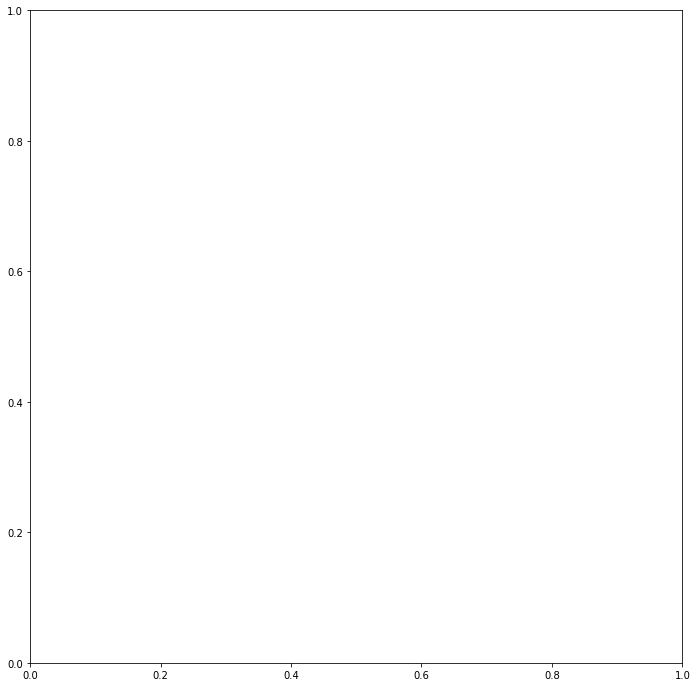

In [199]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 12))
ax.imshow(img[:,:, cmap='gray')
  
plt.tight_layout()            
plt.show()